# Lab 3: Gesture Recognition using Convolutional Neural Networks

In this lab you will train a convolutional neural network to make classifications on different hand gestures. By the end of the lab, you should be able to:

1. Load and split data for training, validation and testing
2. Train a Convolutional Neural Network
3. Apply transfer learning to improve your model

Note that for this lab we will not be providing you with any starter code. You should be able to take the code used in previous labs, tutorials and lectures and modify it accordingly to complete the tasks outlined below.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information. Make sure to review the PDF submission to ensure that your answers are easy to read. Make sure that your text is not cut off at the margins.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1Z45DRvHmtbjYhTtfjp1qC2f9gR6PTp8u?usp=sharing

## Dataset

American Sign Language (ASL) is a complete, complex language that employs signs made by moving the
hands combined with facial expressions and postures of the body. It is the primary language of many
North Americans who are deaf and is one of several communication options used by people who are deaf or
hard-of-hearing. The hand gestures representing English alphabet are shown below. This lab focuses on classifying a subset
of these hand gesture images using convolutional neural networks. Specifically, given an image of a hand
showing one of the letters A-I, we want to detect which letter is being represented.

![alt text](https://www.disabled-world.com/pics/1/asl-alphabet.jpg)

## Part B. Building a CNN [50 pt]

For this lab, we are not going to give you any starter code. You will be writing a convolutional neural network
from scratch. You are welcome to use any code from previous labs, lectures and tutorials. You should also
write your own code.

You may use the PyTorch documentation freely. You might also find online tutorials helpful. However, all
code that you submit must be your own.

Make sure that your code is vectorized, and does not contain obvious inefficiencies (for example, unecessary
for loops, or unnecessary calls to unsqueeze()). Ensure enough comments are included in the code so that
your TA can understand what you are doing. It is your responsibility to show that you understand what you
write.

**This is much more challenging and time-consuming than the previous labs.** Make sure that you
give yourself plenty of time by starting early.

### 1. Data Loading and Splitting [5 pt]

Download the anonymized data provided on Quercus. To allow you to get a heads start on this project we will provide you with sample data from previous years. Split the data into training, validation, and test sets.

Note: Data splitting is not as trivial in this lab. We want our test set to closely resemble the setting in which
our model will be used. In particular, our test set should contain hands that are never seen in training!

Explain how you split the data, either by describing what you did, or by showing the code that you used.
Justify your choice of splitting strategy. How many training, validation, and test images do you have?

For loading the data, you can use plt.imread as in Lab 1, or any other method that you choose. You may find
torchvision.datasets.ImageFolder helpful. (see https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=image%20folder#torchvision.datasets.ImageFolder
)

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
import os
import random
import shutil

In [ ]:
base_dir = "C:/Users/xiong/OneDrive - University of Toronto/桌面/xiwei/Lab3 Dataset/Lab3_Gestures_Summer" # connect to local runtime

In [ ]:
# DO NOT RE RUN EVERY TIME

# paths and seed
random.seed(25)

# base_dir = '/content/gdrive/MyDrive/APS360/Lab3 Dataset/Lab3_Gestures_Summer' # if use google drive

splits = ['train', 'val', 'test']

# identify class folders (A–I)
class_dirs = [
  d for d in os.listdir(base_dir)
  if os.path.isdir(os.path.join(base_dir, d)) and d not in splits
]

# create split directories with class subfolders
for split in splits:
  for cls in class_dirs:
    os.makedirs(os.path.join(base_dir, split, cls), exist_ok=True)

# each class, shuffle and split
for cls in class_dirs:
  cls_path = os.path.join(base_dir, cls)
  images = [fname for fname in os.listdir(cls_path) if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]
  random.shuffle(images)

  n = len(images)
  n_train = int(n * 0.70)
  n_val = int(n * 0.15)
  n_test = n - n_train - n_val

  train_imgs = images[:n_train]
  val_imgs = images[n_train:n_train + n_val]
  test_imgs = images[n_train + n_val:]

  # copy into correct split/class folders
  for fname in train_imgs:
    src = os.path.join(cls_path, fname)
    dst = os.path.join(base_dir, 'train', cls, fname)
    shutil.copy(src, dst)

  for fname in val_imgs:
    src = os.path.join(cls_path, fname)
    dst = os.path.join(base_dir, 'val', cls, fname)
    shutil.copy(src, dst)

  for fname in test_imgs:
    src = os.path.join(cls_path, fname)
    dst = os.path.join(base_dir, 'test', cls, fname)
    shutil.copy(src, dst)

# print counts
for split in splits:
  total = sum(len(files) for _, _, files in os.walk(os.path.join(base_dir, split)))
  print(f"{split.capitalize()}: {total} images")

Train: 1548 images
Val: 330 images
Test: 341 images


In [ ]:
data_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(),transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std= [0.229, 0.224, 0.225]
)]) # resizes each image to 224×224 pixels, converts it to a PyTorch tensor, and normalizes its RGB channels using the mean and standard deviation from the ImageNet dataset

data_dir = "C:/Users/xiong/OneDrive - University of Toronto/桌面/xiwei/Lab3 Dataset/Lab3_Gestures_Summer/"
# data_dir = '/content/gdrive/MyDrive/APS360/Lab3 Dataset/Lab3_Gestures_Summer/' # if google drive

# Three folders
train_data = torchvision.datasets.ImageFolder(data_dir + 'train', transform=data_transform)
val_data = torchvision.datasets.ImageFolder(data_dir + 'val', transform=data_transform)
test_data = torchvision.datasets.ImageFolder(data_dir + 'test', transform=data_transform)

classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']

# load Data
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

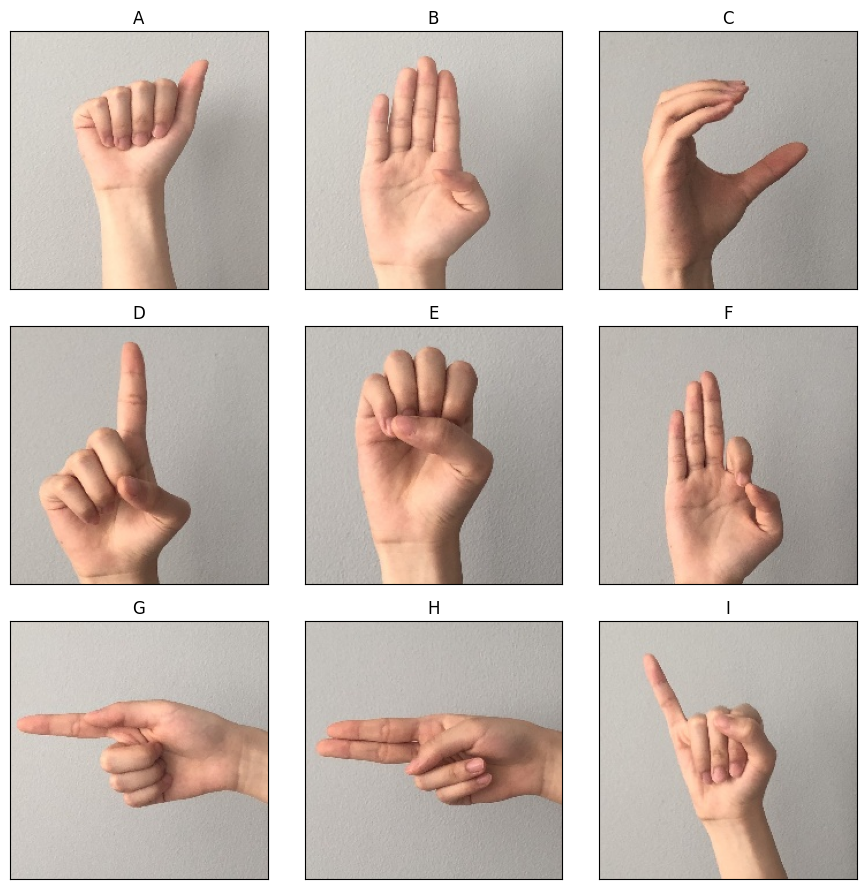

In [ ]:
# find one index per class
samples_per_class = {}
for idx, (_, label) in enumerate(train_data.samples):
  if label not in samples_per_class:
    samples_per_class[label] = idx
  if len(samples_per_class) == len(classes):
    break

# load those images into a batch
imgs = []
lbls = []
for label, idx in sorted(samples_per_class.items()):
  img, _ = train_data[idx] # train_data applies data_transform already
  imgs.append(img)
  lbls.append(label)
imgs = torch.stack(imgs) # shape [9, 3, 224, 224]
lbls = torch.tensor(lbls)

# unnormalize back to [0,1]
mean = torch.tensor([0.485, 0.456, 0.406])[:, None, None]
std  = torch.tensor([0.229, 0.224, 0.225])[:, None, None]
imgs_disp = imgs * std + mean

# plot in 3×3 grid to show samplles
fig = plt.figure(figsize=(9,9))
for i in range(len(classes)):
  ax = fig.add_subplot(3, 3, i+1, xticks=[], yticks=[])
  img = imgs_disp[i].permute(1,2,0).cpu().numpy()
  ax.imshow(img)
  ax.set_title(classes[lbls[i].item()])
plt.tight_layout()
plt.show()

**Answer:**

A 70/15/15 split gives this model enough data (70%) to learn robust features while reserving a separate validation set (15%) for tuning hyperparameters without peeking at test results, and a held‐out test set (15%) to provide an unbiased estimate of final performance. By stratifying each class equally into these proportions, it ensures balanced representation across A–I, maintain reproducibility with a fixed seed, and keep its training, validation, and testing pipelines fully isolated.

Train: 1548 images

Val: 330 images

Test: 341 images

### 2. Model Building and Sanity Checking [15 pt]

### Part (a) Convolutional Network - 5 pt

Build a convolutional neural network model that takes the (224x224 RGB) image as input, and predicts the gesture
letter. Your model should be a subclass of nn.Module. Explain your choice of neural network architecture: how
many layers did you choose? What types of layers did you use? Were they fully-connected or convolutional?
What about other decisions like pooling layers, activation functions, number of channels / hidden units?

**Answer:**

This model uses three convolutional blocks—each a convolution (with parameterized kernel size 3*3 by default), ReLU activation, and 2×2 max‐pool—doubling channels from 3->32->64->128 and reducing spatial resolution from 224->28. This depth lets the network learn progressively more complex features (edges->textures->shapes) while pooling builds translation invariance and controls computational cost.

After flattening the final 128×28×28 feature map, it applies two fully-connected layers: a 3456->256 hidden layer with ReLU and 50% dropout to prevent overfitting, followed by a 256->9 output layer that produces logits for each ASL letter. This combination of convolutional feature extraction and a compact classification head balances representational power with trainability on a modest dataset.

In [ ]:
class ASLCNN(nn.Module):
  def __init__(self, kernel_sizes, num_classes=9, name="ASLCNN"):
    super().__init__()
    self.name = name

    # three kernel sizes (changeable)
    k1, k2, k3 = kernel_sizes

    # with variable kernels
    self.conv1 = nn.Conv2d(3,  32, kernel_size=k1, padding=k1//2)
    self.pool1 = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=k2, padding=k2//2)
    self.pool2 = nn.MaxPool2d(2, 2)
    self.conv3 = nn.Conv2d(64,128, kernel_size=k3, padding=k3//2)
    self.pool3 = nn.MaxPool2d(2, 2)

    flat = 128 * 28 * 28
    self.fc1 = nn.Linear(flat, 256)
    self.dropout = nn.Dropout(0.5)
    self.fc2 = nn.Linear(256, num_classes)

  def forward(self, x):
    x = self.pool1(F.relu(self.conv1(x)))
    x = self.pool2(F.relu(self.conv2(x)))
    x = self.pool3(F.relu(self.conv3(x)))
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    return self.fc2(x)

### Part (b) Training Code - 5 pt

Write code that trains your neural network given some training data. Your training code should make it easy
to tweak the usual hyperparameters, like batch size, learning rate, and the model object itself. Make sure
that you are checkpointing your models from time to time (the frequency is up to you). Explain your choice
of loss function and optimizer.

In [ ]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
use_cuda = True

In [ ]:
def get_accuracy(model, data_loader):
  device = next(model.parameters()).device
  model.eval()
  correct, total = 0, 0
  with torch.no_grad():
    for imgs, labels in data_loader:
      imgs, labels = imgs.to(device), labels.to(device)
      outputs = model(imgs)
      preds = outputs.argmax(dim=1)
      correct += (preds == labels).sum().item()
      total += labels.size(0)
  return correct / total

In [ ]:
def get_model_name(name, batch_size, learn_rate, epoch):
  return f"model_{name}_bs{batch_size}_epoch{epoch}_lr{learn_rate}.pt"

In [ ]:
def train(model, train_dataset, val_dataset, batch_size=128, num_epochs=20, learn_rate=0.001, use_cuda=True):
  """
  Trains model on train_dataset and validates on val_dataset.
  Returns: train_acc, val_acc, epochs_array
  """
  device = 'cuda' if use_cuda and torch.cuda.is_available() else 'cpu' #### run on gpu otherwise super slwo

  torch.manual_seed(25)
  device = 'cuda' if use_cuda and torch.cuda.is_available() else 'cpu'
  model = model.to(device)

  train_loader = torch.utils.data.DataLoader(
      train_dataset, batch_size=batch_size, shuffle=True, pin_memory=use_cuda
  )
  val_loader = torch.utils.data.DataLoader(
      val_dataset, batch_size=batch_size, shuffle=False, pin_memory=use_cuda
  )

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learn_rate)

  train_acc = np.zeros(num_epochs)
  val_acc = np.zeros(num_epochs)

  for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for imgs, labels in train_loader:
      imgs, labels = imgs.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = model(imgs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item() * imgs.size(0)

    avg_loss = running_loss / len(train_loader.dataset)

    # \compute accuracies once per epoch
    train_acc[epoch] = get_accuracy(model, train_loader)
    val_acc[epoch] = get_accuracy(model, val_loader)

    # save checkpoint
    ckpt_path = get_model_name(model.name, batch_size, learn_rate, epoch)
    torch.save(model.state_dict(), ckpt_path)

    print(f"Epoch {epoch+1}/{num_epochs} — "
          f"Loss: {avg_loss:.4f} | "
          f"Train Acc: {train_acc[epoch]:.3f} | "
          f"Val Acc:   {val_acc[epoch]:.3f}")

  epochs = np.arange(1, num_epochs + 1)

  # plot accuracy curves
  plt.figure(figsize=(8,4))
  plt.plot(epochs, train_acc, '-o', label='Train Acc')
  plt.plot(epochs, val_acc, '-o', label='Val Acc')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title(f"{model.name}: bs={batch_size}, lr={learn_rate}")
  plt.legend()
  plt.show()

  return train_acc, val_acc, epochs

**Answer:**

For loss function, I chose cross entropy loss combines softmax + NLL, which is pretty standard for classification. It is ideal for multi-class problems, it combines softmax and negative-log-likelihood to directly penalize incorrect class scores.

For optimizer, Adam adapts per-parameter learning rates using momentum, and it often converge faster than just SGD and reduce manual LR tuning.


### Part (c) “Overfit” to a Small Dataset - 5 pt

One way to sanity check our neural network model and training code is to check whether the model is capable
of “overfitting” or “memorizing” a small dataset. A properly constructed CNN with correct training code
should be able to memorize the answers to a small number of images quickly.

Construct a small dataset (e.g. just the images that you have collected). Then show that your model and
training code is capable of memorizing the labels of this small data set.

With a large batch size (e.g. the entire small dataset) and learning rate that is not too high, You should be
able to obtain a 100% training accuracy on that small dataset relatively quickly (within 200 iterations).

In [ ]:
from torch.utils.data import Subset

In [ ]:
import torch
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# small subset from train_dataset
small_size = 20
imgs_list, labs_list = [], []
for i in range(small_size):
  img, lab = train_data[i]    # train_dataset from random_split
  imgs_list.append(img)
  labs_list.append(lab)

# batch and move to GPU
all_imgs = torch.stack(imgs_list).to(device) # [20, 3, 224, 224]
all_labs = torch.tensor(labs_list, device=device) # [20]

# model, optimizer, loss
overfit_model = ASLCNN(kernel_sizes=[3, 3, 3], num_classes=9).to(device)
optimizer = Adam(overfit_model.parameters(), lr=0.01)
criterion = CrossEntropyLoss()

# training
for step in range(1, 201):
  overfit_model.train()
  optimizer.zero_grad()
  outputs = overfit_model(all_imgs)
  loss = criterion(outputs, all_labs)
  loss.backward()
  optimizer.step()

  if step % 20 == 0:
    preds = outputs.argmax(dim=1)
    acc = (preds == all_labs).float().mean().item()
    print(f"Step {step:3d} — loss: {loss.item():.4f}, accuracy: {acc*100:.1f}%")
    if acc == 1.0:
      print("Overfit achieved (100% training accuracy).")
      break

Step  20 — loss: 0.0000, accuracy: 100.0%
Overfit achieved (100% training accuracy).


**Answer:**

This code explicitly constructs a “miniature” dataset of just 20 examples, packs them into a single large batch, and then runs gradient‐descent updates on that same batch for up to 200 iterations with a relatively high learning rate. By feeding the entire small dataset in one go (all_imgs, all_labs), the model sees exactly the same examples every step, which lets it literally memorize their labels rather than generalize. Every 20 steps it computes accuracy on that identical batch, and as soon as it hits 100%—often well before 200 iterations—it prints “Overfit achieved.” Hitting perfect accuracy so quickly on such a small fixed batch confirms both that your network has enough capacity and that your training loop is implemented correctly.

### 3. Hyperparameter Search [15 pt]

### Part (a) - 3 pt

List 3 hyperparameters that you think are most worth tuning. Choose at least one hyperparameter related to
the model architecture.

**Answer:**

* Learning Rate
* Batch Size
* Kernel Size

### Part (b) - 5 pt

Tune the hyperparameters you listed in Part (a), trying as many values as you need to until you feel satisfied
that you are getting a good model. Plot the training curve of at least 4 different hyperparameter settings.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Epoch 1/20 — Loss: 2.5768 | Train Acc: 0.338 | Val Acc:   0.321
Epoch 2/20 — Loss: 1.5221 | Train Acc: 0.618 | Val Acc:   0.579
Epoch 3/20 — Loss: 1.1871 | Train Acc: 0.724 | Val Acc:   0.676
Epoch 4/20 — Loss: 1.0118 | Train Acc: 0.741 | Val Acc:   0.673
Epoch 5/20 — Loss: 0.9067 | Train Acc: 0.784 | Val Acc:   0.685
Epoch 6/20 — Loss: 0.8177 | Train Acc: 0.816 | Val Acc:   0.727
Epoch 7/20 — Loss: 0.6994 | Train Acc: 0.859 | Val Acc:   0.739
Epoch 8/20 — Loss: 0.6016 | Train Acc: 0.862 | Val Acc:   0.730
Epoch 9/20 — Loss: 0.6139 | Train Acc: 0.897 | Val Acc:   0.730
Epoch 10/20 — Loss: 0.4847 | Train Acc: 0.912 | Val Acc:   0.767
Epoch 11/20 — Loss: 0.4487 | Train Acc: 0.942 | Val Acc:   0.755
Epoch 12/20 — Loss: 0.3238 | Train Acc: 0.950 | Val Acc:   0.736
Epoch 13/20 — Loss: 0.2954 | Train Acc: 0.972 | Val Acc:   0.791
Epoch 14/20 — Loss: 0.2738 | Train Acc: 0.980 | Val Acc:   0.782
Epoch 15/20 — Loss: 0.2348 | Train Acc: 0.982 | Val Acc:   0.776
Epoch 16/20 — Loss: 0.2154 | Train

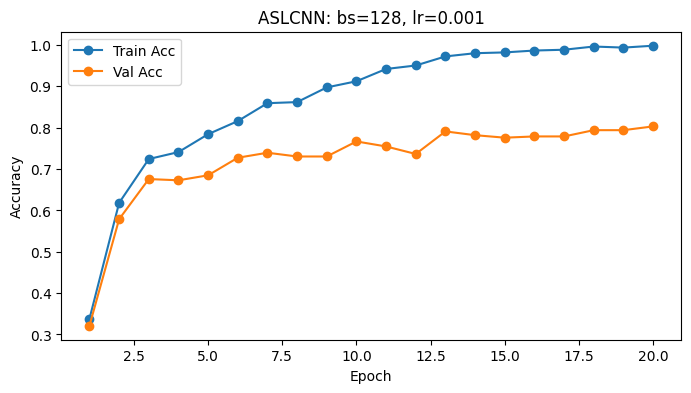

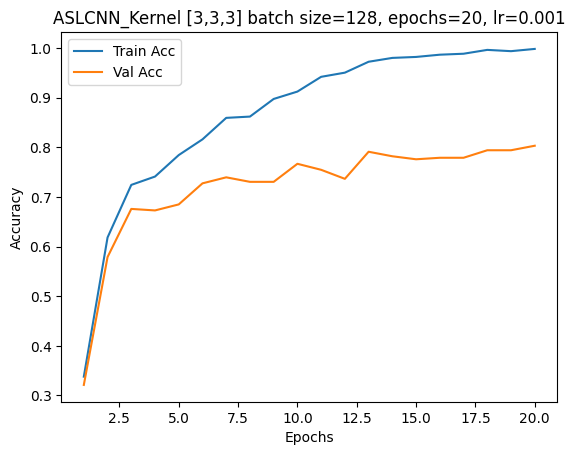

In [ ]:
# (1) instantiate model with kernel [3,3,3], batch size=128, epochs=20, lr=0.001
CNN = ASLCNN(kernel_sizes=[3, 3, 3])

#train
train_acc, val_acc, epochs = train(
    CNN,
    train_data,
    val_data,
    batch_size=128,
    num_epochs=20,
    learn_rate=0.001,
    use_cuda=True
)

# plot
plt.plot(epochs, train_acc, label='Train Acc')
plt.plot(epochs, val_acc,   label='Val Acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("ASLCNN_Kernel [3,3,3] batch size=128, epochs=20, lr=0.001")
plt.legend()
plt.show()

Epoch 1/20 — Loss: 2.7348 | Train Acc: 0.389 | Val Acc:   0.367
Epoch 2/20 — Loss: 1.4874 | Train Acc: 0.612 | Val Acc:   0.573
Epoch 3/20 — Loss: 1.1646 | Train Acc: 0.725 | Val Acc:   0.667
Epoch 4/20 — Loss: 1.0024 | Train Acc: 0.769 | Val Acc:   0.694
Epoch 5/20 — Loss: 0.9199 | Train Acc: 0.789 | Val Acc:   0.721
Epoch 6/20 — Loss: 0.7751 | Train Acc: 0.836 | Val Acc:   0.721
Epoch 7/20 — Loss: 0.6556 | Train Acc: 0.880 | Val Acc:   0.748
Epoch 8/20 — Loss: 0.6120 | Train Acc: 0.866 | Val Acc:   0.733
Epoch 9/20 — Loss: 0.5284 | Train Acc: 0.919 | Val Acc:   0.761
Epoch 10/20 — Loss: 0.4400 | Train Acc: 0.934 | Val Acc:   0.742
Epoch 11/20 — Loss: 0.4109 | Train Acc: 0.948 | Val Acc:   0.755
Epoch 12/20 — Loss: 0.3564 | Train Acc: 0.964 | Val Acc:   0.761
Epoch 13/20 — Loss: 0.2840 | Train Acc: 0.968 | Val Acc:   0.773
Epoch 14/20 — Loss: 0.2589 | Train Acc: 0.982 | Val Acc:   0.782
Epoch 15/20 — Loss: 0.2498 | Train Acc: 0.970 | Val Acc:   0.776
Epoch 16/20 — Loss: 0.2127 | Train

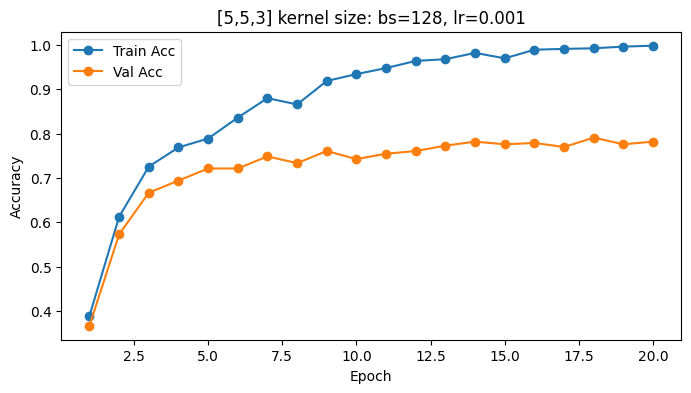

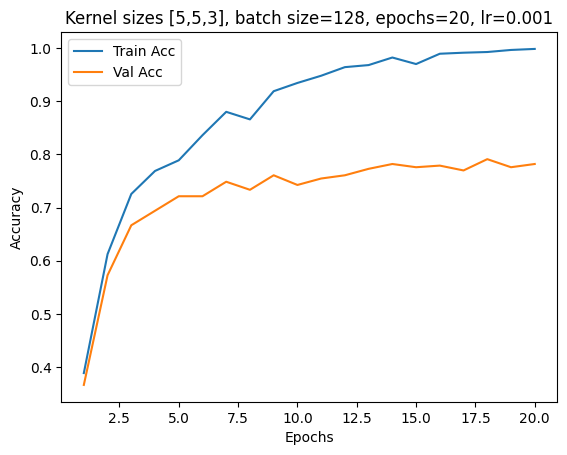

In [ ]:
# (2) instantiate with a new set of kernel sizes, e.g. larger kernels
# [5,5,3] instead of the default [3,3,3]
CNN = ASLCNN(kernel_sizes=[5, 5, 3], name = "[5,5,3] kernel size")

# train
train_acc, val_acc, epochs = train(
    CNN,
    train_data,
    val_data,
    batch_size=128,
    num_epochs=20,
    learn_rate=0.001,
    use_cuda=True
)

# plot
plt.plot(epochs, train_acc, label='Train Acc')
plt.plot(epochs, val_acc,   label='Val Acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Kernel sizes [5,5,3], batch size=128, epochs=20, lr=0.001")
plt.legend()
plt.show()

Epoch 1/20 — Loss: 10.5560 | Train Acc: 0.118 | Val Acc:   0.115
Epoch 2/20 — Loss: 1.7596 | Train Acc: 0.577 | Val Acc:   0.512
Epoch 3/20 — Loss: 1.3290 | Train Acc: 0.686 | Val Acc:   0.642
Epoch 4/20 — Loss: 1.0455 | Train Acc: 0.735 | Val Acc:   0.655
Epoch 5/20 — Loss: 1.0027 | Train Acc: 0.761 | Val Acc:   0.664
Epoch 6/20 — Loss: 0.8021 | Train Acc: 0.829 | Val Acc:   0.709
Epoch 7/20 — Loss: 0.6578 | Train Acc: 0.858 | Val Acc:   0.724
Epoch 8/20 — Loss: 0.5143 | Train Acc: 0.924 | Val Acc:   0.770
Epoch 9/20 — Loss: 0.4338 | Train Acc: 0.930 | Val Acc:   0.742
Epoch 10/20 — Loss: 0.3804 | Train Acc: 0.962 | Val Acc:   0.770
Epoch 11/20 — Loss: 0.2604 | Train Acc: 0.979 | Val Acc:   0.782
Epoch 12/20 — Loss: 0.2434 | Train Acc: 0.986 | Val Acc:   0.748
Epoch 13/20 — Loss: 0.1861 | Train Acc: 0.991 | Val Acc:   0.779
Epoch 14/20 — Loss: 0.1748 | Train Acc: 0.997 | Val Acc:   0.785
Epoch 15/20 — Loss: 0.1252 | Train Acc: 0.995 | Val Acc:   0.785
Epoch 16/20 — Loss: 0.1250 | Trai

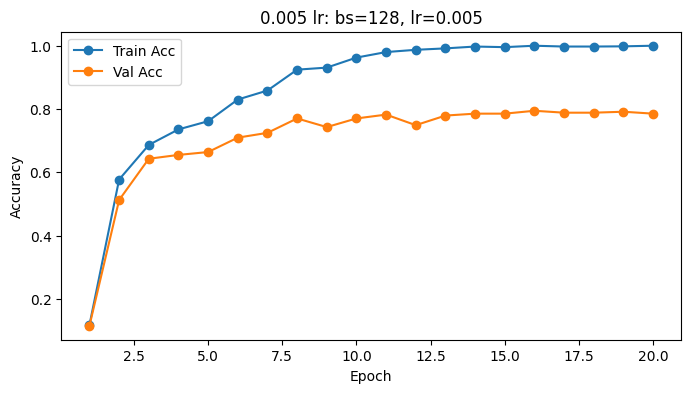

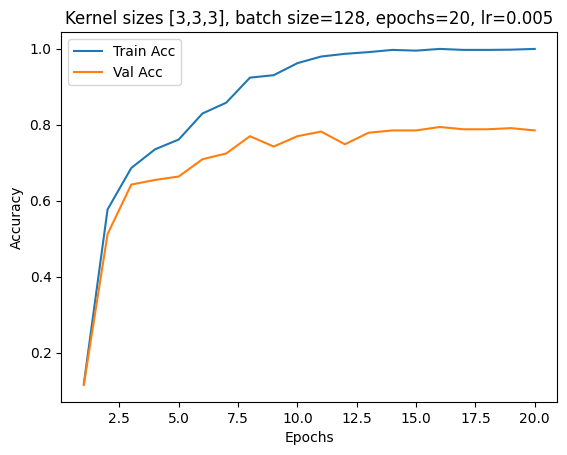

In [ ]:
# (3) change the learning rate from 0.001 to 0.005
CNN = ASLCNN(kernel_sizes=[3, 3, 3], name = "0.005 lr")

train_acc, val_acc, epochs = train(
    CNN,
    train_data,
    val_data,
    batch_size=128,
    num_epochs=20,
    learn_rate=0.005,
    use_cuda=True
)

plt.plot(epochs, train_acc, label='Train Acc')
plt.plot(epochs, val_acc,   label='Val Acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Kernel sizes [3,3,3], batch size=128, epochs=20, lr=0.005")
plt.legend()
plt.show()

Epoch 1/20 — Loss: 2.0307 | Train Acc: 0.642 | Val Acc:   0.564
Epoch 2/20 — Loss: 1.1944 | Train Acc: 0.697 | Val Acc:   0.627
Epoch 3/20 — Loss: 0.9543 | Train Acc: 0.774 | Val Acc:   0.661
Epoch 4/20 — Loss: 0.8085 | Train Acc: 0.806 | Val Acc:   0.697
Epoch 5/20 — Loss: 0.7212 | Train Acc: 0.867 | Val Acc:   0.742
Epoch 6/20 — Loss: 0.5578 | Train Acc: 0.895 | Val Acc:   0.755
Epoch 7/20 — Loss: 0.4338 | Train Acc: 0.935 | Val Acc:   0.770
Epoch 8/20 — Loss: 0.4087 | Train Acc: 0.963 | Val Acc:   0.782
Epoch 9/20 — Loss: 0.3339 | Train Acc: 0.981 | Val Acc:   0.779
Epoch 10/20 — Loss: 0.2569 | Train Acc: 0.987 | Val Acc:   0.797
Epoch 11/20 — Loss: 0.2167 | Train Acc: 0.992 | Val Acc:   0.770
Epoch 12/20 — Loss: 0.1675 | Train Acc: 0.997 | Val Acc:   0.794
Epoch 13/20 — Loss: 0.1426 | Train Acc: 0.997 | Val Acc:   0.800
Epoch 14/20 — Loss: 0.1218 | Train Acc: 0.999 | Val Acc:   0.797
Epoch 15/20 — Loss: 0.1133 | Train Acc: 0.999 | Val Acc:   0.794
Epoch 16/20 — Loss: 0.0892 | Train

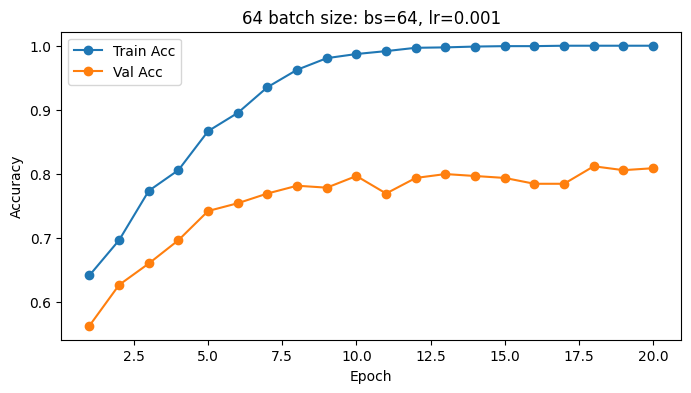

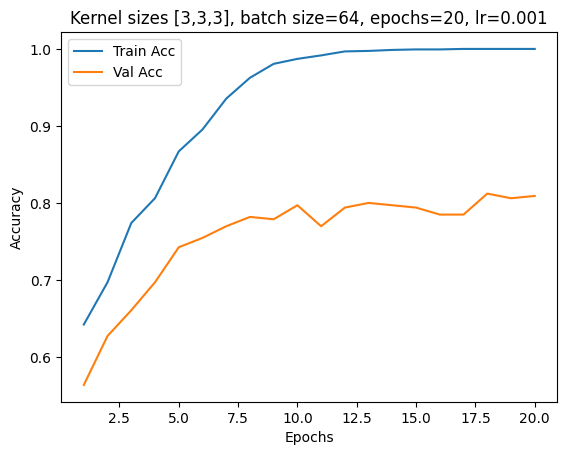

In [ ]:
# (4) change the batch size from 128 to 64
CNN = ASLCNN(kernel_sizes=[3, 3, 3], name = "64 batch size")

train_acc, val_acc, epochs = train(
    CNN,
    train_data,
    val_data,
    batch_size=64,
    num_epochs=20,
    learn_rate=0.001,
    use_cuda=True
)

plt.plot(epochs, train_acc, label='Train Acc')
plt.plot(epochs, val_acc, label='Val Acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Kernel sizes [3,3,3], batch size=64, epochs=20, lr=0.001")
plt.legend()
plt.show()

### Part (c) - 3 pt
Choose the best model out of all the ones that you have trained. Justify your choice.

**Answer:**

Out of the four experiments demonstrated in part b earlier, we could see that for the model "64 batch size", its validation accuracy is the highest(0.809) and also it reached 1.00 training accuracy (although some other model also achieved 1 at epoch 20). This run clearly outperforms the others because it achieves the highest peak validation accuracy (~81.2% at epoch 18) while still showing a healthy gap (train→val) that indicates it’s learning generalizable features rather than simply memorizing. Its steady climb in val acc through epoch 10 (up to ~79.7%) and further improvement to ~81.2% before a slight plateau demonstrates that the chosen hyperparameters struck the best balance of capacity (kernel sizes, batch size, learning rate) for your dataset. Also the plot shows that it has the right capacity to learn our ASL gestures without severely overfitting. Early on, both training and validation accuracy climb together—indicating no underfitting. It then edges up to 81.2% before plateauing, with a moderate train–val gap (100% vs. 81.2%) that confirms it’s not just memorizing (overfitting) but genuinely generalizing better than the other hyperparameter settings.

In [ ]:
CNN_best = ASLCNN(kernel_sizes=[3, 3, 3], name="64 batch size")

ckpt_path = get_model_name(
    CNN_best.name,
    batch_size=64,
    learn_rate=0.001,
    epoch=19
)
print("Loading weights from:", ckpt_path)

state = torch.load(ckpt_path, map_location=device)
CNN_best.load_state_dict(state)

Loading weights from: model_64 batch size_bs64_epoch19_lr0.001.pt


<All keys matched successfully>

### Part (d) - 4 pt
Report the test accuracy of your best model. You should only do this step once and prior to this step you should have only used the training and validation data.

In [ ]:
CNN_best.to(device)

test_acc = get_accuracy(CNN_best, test_loader)
print(f"Test Accuracy: {test_acc*100:.2f}%")

Test Accuracy: 78.30%


**Answer:**

Output showed a 78.30% accuracy on this model.

### 4. Transfer Learning [15 pt]
For many image classification tasks, it is generally not a good idea to train a very large deep neural network
model from scratch due to the enormous compute requirements and lack of sufficient amounts of training
data.

One of the better options is to try using an existing model that performs a similar task to the one you need
to solve. This method of utilizing a pre-trained network for other similar tasks is broadly termed **Transfer
Learning**. In this assignment, we will use Transfer Learning to extract features from the hand gesture
images. Then, train a smaller network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, convolution layers extract various features from the images which
get utilized by the fully connected layers for correct classification. AlexNet architecture played a pivotal
role in establishing Deep Neural Nets as a go-to tool for image classification problems and we will use an
ImageNet pre-trained AlexNet model to extract features in this assignment.

### Part (a) - 5 pt
Here is the code to load the AlexNet network, with pretrained weights. When you first run the code, PyTorch
will download the pretrained weights from the internet.

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

The alexnet model is split up into two components: *alexnet.features* and *alexnet.classifier*. The
first neural network component, *alexnet.features*, is used to compute convolutional features, which are
taken as input in *alexnet.classifier*.

The neural network alexnet.features expects an image tensor of shape Nx3x224x224 as input and it will
output a tensor of shape Nx256x6x6 . (N = batch size).

Compute the AlexNet features for each of your training, validation, and test data. Here is an example code
snippet showing how you can compute the AlexNet features for some images (your actual code might be
different):

In [ ]:
import torchvision.models as models

# load pretrained AlexNet
alexnet = models.alexnet(pretrained=True).to(device)
alexnet.eval()

# save features into structured folders: alexnet_features/train/A/0.pt ......
def storeFeatures(loader, split_name):
  save_root = os.path.join(base_dir, 'alexnet_features', split_name)
  num = 0
  with torch.no_grad():
    for img, label in loader:
      img = img.to(device)
      features = alexnet.features(img).cpu().squeeze(0)  # shape: [256, 6, 6]
      class_name = classes[label.item()]
      class_dir = os.path.join(save_root, class_name)
      os.makedirs(class_dir, exist_ok=True)
      torch.save(features, os.path.join(class_dir, f"{num}.pt"))
      num += 1

In [ ]:
# paths
train_path = os.path.join(base_dir, 'train')
valid_path = os.path.join(base_dir, 'val')
test_path = os.path.join(base_dir, 'test')

# transform (224x224 with normalization for AlexNet)
transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std= [0.229, 0.224, 0.225])
])

# load datasets
train_dataset = torchvision.datasets.ImageFolder(train_path, transform=transform)
valid_dataset = torchvision.datasets.ImageFolder(valid_path, transform=transform)
test_dataset = torchvision.datasets.ImageFolder(test_path, transform=transform)

# use batch_size=1 to save features individually
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=1)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1)

**Save the computed features**. You will be using these features as input to your neural network in Part
(b), and you do not want to re-compute the features every time. Instead, run *alexnet.features* once for
each image, and save the result.

In [ ]:
storeFeatures(train_loader, 'train')
storeFeatures(valid_loader, 'val')
storeFeatures(test_loader, 'test')

### Part (b) - 3 pt
Build a convolutional neural network model that takes as input these AlexNet features, and makes a
prediction. Your model should be a subclass of nn.Module.

Explain your choice of neural network architecture: how many layers did you choose? What types of layers
did you use: fully-connected or convolutional? What about other decisions like pooling layers, activation
functions, number of channels / hidden units in each layer?

Here is an example of how your model may be called:

**Answer:**

For the classifier built on top of the AlexNet features, I used a simple fully connected neural network architecture. Since the pretrained AlexNet model already extracts well rounded spatial features through its convolutional and pooling layers, my custom model only needed to map these features to gesture classes.

The input to the classifier is a flattened feature tensor of size 256*6*6, which feeds into a fully connected layer with 512 hidden units and ReLU activation to introduce non-linearity. A dropout layer with a rate of 0.5 follows to help prevent overfitting. Finally, a second fully connected layer outputs logits for the 9 gesture classes (A to I). This is not only minimal but aalso effective, and it can focus on classification while reusing the pretrained convolutional filters for feature extraction.

In [ ]:
from torch.utils.data import Dataset, DataLoader
import glob
import torch

class FeatureDataset(Dataset):
  def __init__(self, feature_root):
    self.samples = []
    for i, cls in enumerate(classes):
      class_folder = os.path.join(feature_root, cls)
      if os.path.isdir(class_folder):
        files = glob.glob(os.path.join(class_folder, '*.pt'))
        for f in files:
          self.samples.append((f, i))
    print(f"Loaded {len(self.samples)} samples from: {feature_root}")

  def __len__(self):
    return len(self.samples)

  def __getitem__(self, idx):
    path, label = self.samples[idx]
    feat = torch.load(path)  # shape: [256, 6, 6]
    return feat, label

In [ ]:
# paths to saved AlexNet features
train_feat_dir = os.path.join(base_dir, 'alexnet_features', 'train')
val_feat_dir = os.path.join(base_dir, 'alexnet_features', 'val')
test_feat_dir = os.path.join(base_dir, 'alexnet_features', 'test')

#create datasets
train_featset = FeatureDataset(train_feat_dir)
val_featset = FeatureDataset(val_feat_dir)
test_featset = FeatureDataset(test_feat_dir)

# create loaders
train_featloader = DataLoader(train_featset, batch_size=64, shuffle=True)
val_featloader = DataLoader(val_featset, batch_size=64)
test_featloader = DataLoader(test_featset, batch_size=64)

Loaded 1548 samples from: C:/Users/xiong/OneDrive - University of Toronto/桌面/xiwei/Lab3 Dataset/Lab3_Gestures_Summer/alexnet_features\train
Loaded 330 samples from: C:/Users/xiong/OneDrive - University of Toronto/桌面/xiwei/Lab3 Dataset/Lab3_Gestures_Summer/alexnet_features\val
Loaded 341 samples from: C:/Users/xiong/OneDrive - University of Toronto/桌面/xiwei/Lab3 Dataset/Lab3_Gestures_Summer/alexnet_features\test


In [ ]:
class AlexNetClassifier(nn.Module):
  def __init__(self, num_classes=9, name="AlexNetClassifier"):
    super().__init__()
    self.name = name
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(256 * 6 * 6, 512)
    self.dropout = nn.Dropout(0.5)
    self.fc2 = nn.Linear(512, num_classes)

  def forward(self, x):
    x = self.flatten(x)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    return self.fc2(x)

**Answer:**

This AlexNetClassifier wraps the fully‐connected head of AlexNet (after the convolutional features) into a small, trainable classifier

* nn.Flatten() converts the 4D feature tensor of shape [batch, 256, 6, 6] into a 2D tensor [batch, 256×6×6], so it can feed into linear layers.

* self.fc1 = nn.Linear(256*6*6, 512) is a fully connected layer that projects the 3456-dimensional feature vector down to 512 hidden units.

* F.relu(...) applies a ReLU activation to introduce non-linearity and help the network learn complex decision boundaries.

* nn.Dropout(0.5) randomly zeroes 50% of those 512 activations during training, which helps prevent overfitting by ensuring the classifier doesn’t rely too heavily on any one feature.

* self.fc2 = nn.Linear(512, num_classes) Finally maps the 512-dim vector to the desired number of output classes (9 letters A–I). The raw scores (logits) returned here can then be fed into CrossEntropyLoss or softmax for prediction.

### Part (c) - 5 pt
Train your new network, including any hyperparameter tuning. Plot and submit the training curve of your
best model only.

Note: Depending on how you are caching (saving) your AlexNet features, PyTorch might still be tracking
updates to the **AlexNet weights**, which we are not tuning. One workaround is to convert your AlexNet
feature tensor into a numpy array, and then back into a PyTorch tensor.

Epoch 1/20 — Loss: 1.7472 | Train Acc: 0.811 | Val Acc:   0.745
Epoch 2/20 — Loss: 0.3848 | Train Acc: 0.944 | Val Acc:   0.876
Epoch 3/20 — Loss: 0.2016 | Train Acc: 0.982 | Val Acc:   0.897
Epoch 4/20 — Loss: 0.1186 | Train Acc: 0.995 | Val Acc:   0.930
Epoch 5/20 — Loss: 0.0732 | Train Acc: 0.996 | Val Acc:   0.912
Epoch 6/20 — Loss: 0.0494 | Train Acc: 0.997 | Val Acc:   0.921
Epoch 7/20 — Loss: 0.0440 | Train Acc: 0.999 | Val Acc:   0.918
Epoch 8/20 — Loss: 0.0310 | Train Acc: 1.000 | Val Acc:   0.927
Epoch 9/20 — Loss: 0.0292 | Train Acc: 1.000 | Val Acc:   0.939
Epoch 10/20 — Loss: 0.0229 | Train Acc: 1.000 | Val Acc:   0.933
Epoch 11/20 — Loss: 0.0138 | Train Acc: 1.000 | Val Acc:   0.939
Epoch 12/20 — Loss: 0.0150 | Train Acc: 1.000 | Val Acc:   0.924
Epoch 13/20 — Loss: 0.0131 | Train Acc: 1.000 | Val Acc:   0.933
Epoch 14/20 — Loss: 0.0136 | Train Acc: 1.000 | Val Acc:   0.936
Epoch 15/20 — Loss: 0.0103 | Train Acc: 1.000 | Val Acc:   0.933
Epoch 16/20 — Loss: 0.0075 | Train

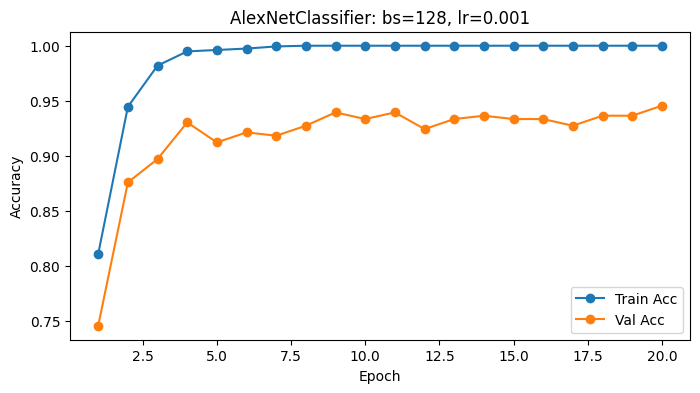

In [ ]:
clf = AlexNetClassifier().to(device)

train_acc, val_acc, epochs = train(
    model=clf,
    train_dataset=train_featset,
    val_dataset=val_featset,
    batch_size=128,
    num_epochs=20,
    learn_rate=0.001,
    use_cuda=True
)

### Part (d) - 2 pt
Report the test accuracy of your best model. How does the test accuracy compare to Part 3(d) without transfer learning?

In [ ]:
test_acc = get_accuracy(clf, test_featloader)
print(f"Transfer Learning Test Accuracy: {test_acc * 100:.2f}%")

Transfer Learning Test Accuracy: 94.72%


**Answer:**

This accuracy is higher than part 3d's, which is 78.30%

This is because AlexNet uses picture features. Because the features are considerably smaller than the original and are used as the input for classification, AlexNet is able to produce better predictions based on the information that the convolutional neural network extracts.